In [25]:
import os
import andes
import numpy as np
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import scipy.stats as stat

from andes.interop.pandapower import to_pandapower, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)
from math import ceil, floor

# virtual inertia scheduling class
from pdpower import make_link_table
from visopf_fixedMD import vis2_tds, loadnn

# function for main
from vistds import get_andes_case, get_load, disturbance

# TDS for VIS

## ini andes attribute

In [26]:
# ini andes attribute
case_path = '/VIS_opf/ieee39_vis_tds.xlsx'
ssa = get_andes_case(case_path)
ssa.TDS.config.no_tqdm = 1 # trun off tds progress fig to speed up sim

# ini load
ptotal = ssa.PQ.as_df()['p0'].sum()
gentotal = ssa.PV.as_df()['Sn'].sum() + ssa.Slack.as_df()['Sn'].sum()
gentotal /= ssa.config.mva
l_rate = ptotal/gentotal

print(f'Gen capacity is: {gentotal} p.u.\
        \nInitial load is: {ptotal.round(4)} p.u.\
        \ninitial load rate is {l_rate*100} %' )


Working directory: "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf"
> Loaded config from file "/Users/buxinshe/.andes/andes.rc"
> Reloaded generated Python code of module "pycode".
Parsing input file "/Users/buxinshe/Documents/git-repo/andes/bshe/VIS_opf/ieee39_vis_tds.xlsx"...
Input file parsed in 0.0678 seconds.
ACEc <1> added BusFreq <BusFreq_21> linked to bus <1>
System internal structure set up in 0.0231 seconds.


Gen capacity is: 109.389 p.u.        
Initial load is: 58.564 p.u.        
initial load rate is 53.537375787327804 %


array([0.04160092, 0.01264898, 0.02950006, 0.0357116 , 0.04872493,
       0.05094144, 0.03748916, 0.03005168, 0.04192332, 0.0536106 ,
       0.04737344, 0.04426615])

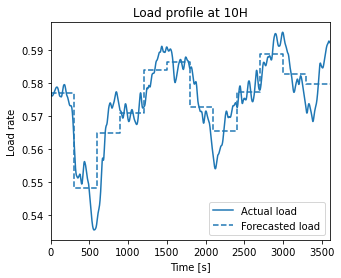

In [27]:
# load profile
data_path = '/VIS_opf/dsyn.csv'
d_syn, load_pic, dpe = get_load(data_path, load_time=10, l_rate=l_rate, scale=1.4)
dpe

# ini visopf instance

In [28]:
# get neural network data
nn_path = '/VIS_opf/NN_train'
nn, norm = loadnn(nn_path)

# ini visopf attribute
ssvis = vis2_tds(norm=norm, nn=nn, dpe=0.05, rocof_lim=0.069, nadir_lim=0.01)

# set vsg gen
vsg_ieee39 = ['PV_1', 'PV_6', 'PV_8', 'PV_9']

# load from andes
ssvis.from_andes(ssa, vsg_ieee39, Sbase=1000)

# add gen cost:
# Note: if two gens have the same cost, optimization results of
#       pandapower and gurobipy may be different.
linearcost = [
                0.5,   # PV_1 vsg
                1, 
                1.2,
                0.8, 
                0.8, 
                0.1,     # PV_6 vsg
                1, 
                0.1,   # PV_8 vsg
                0.1,   # PV_9 vsg 
                1.5    # slack
            ]
            
# set up cost
ssvis.cost['c1'] = linearcost
ssvis.update_dict()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0038 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0043 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
Note: Control (dynamic) parameters are renormalized based on case Sbase rather then to andes base


# ini pandapower instance

In [29]:
# convert andes to a pandapower instance
ssp = to_pandapower(ssa)

# set up pandapower gen cost
gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0037 seconds.
0: |F(x)| = 7.561249598
1: |F(x)| = 2.916162515
2: |F(x)| = 0.1315330771
3: |F(x)| = 0.0003398595952
4: |F(x)| = 4.189813829e-09
Converged in 5 iterations in 0.0040 seconds.
Power flow results are consistent. Conversion is successful.


True

### make link table between pandapower and andes

In [30]:
# --- link pandapower output to andes key ---
ssa_key = make_link_table(ssa)

# make index table to change pandapower and andes setting point
# pandapwoer uses dataframe index, i.g. 0, 1, 2 ....
# andes uses idx to call variable

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})

ssa_key2 = pd.merge(
                        left=ssa_key,
                        right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                        on='stg_idx', 
                        how='left'
                    )

# --- device idx ---
# use to set andes setting point
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()   
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist() 
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist() # static gen
ssa_rg_idx = ssa_key2.rg_idx.dropna().tolist()   # renewable gen: vsg

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl & ssa_key2.stg_u.astype(bool)

ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

## TDS parameters

In [31]:
# --- TDS Constants ---
t_total = 3600  # total simulation time

# update interval
intv_ed = 300   # RTED
intv_agc = 4    # AGC
intv_pq = 1     # PQ load
intv_step = 100 # step change to smooth the setpoitns

# number of intervals
n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- TDS vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars for PI controller
ACE_integral = 0
ACE_raw = 0
Kp = 0.2 # 0.05
Ki = 0.1
ace_res = pd.DataFrame()

# initial load value
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

In [32]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = 1 * ssp.gen.max_p_mw # for AC

# store original generator data
ssp_gen0 = ssp.gen.copy()

# store visopf output
vis_res = {}

for time in range(t_total):  # t_total

    # ----------------------- RTED (VIS opf) interval -------------------------
    if time % intv_ed == 0:
        """
            RTED update with vis opf

            attributes:
            ----------
            - 01 get disturbance
            - 02 update visopf instance
            - 03 update pandapower instance
            - 04 update andes instance
        """
        # --- 01 get disturbance ---
        idx_ed = time // intv_ed
        load, dpe, dvsg_capacity = disturbance(d_syn, idx_ed, intv_ed)

        # --- 02 update visopf instance ---
        # load
        ssvis.load['p0'] = ssa_p0 * load # visopf load update
        # dpe
        ssvis.dpe = dpe
        # vsg gen capacity
        # TODO ... update vsg gen capacity of visopf

        ssvis.update_dict()

        # solve visopf
        sgres, vsg_res, sys_MD = ssvis.get_res()
        # save visopf result
        vis_res[f'sg_{idx_ed}'] = sgres.copy()
        vis_res[f'vsg_{idx_ed}'] = vsg_res.copy()
        vis_res[f'MDsys_{idx_ed}'] = sys_MD.copy()
        vis_res[f'dpe_{idx_ed}'] = dpe
        vis_res[f'cost_{idx_ed}'] = ssvis.mdl.getObjective().getValue()

        # --- 03 update pandapwoer instance ---
        # load
        ssp.load.scaling = load
        # pandapower gen
        ssp_gen = pd.merge(
                            left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                            right=sgres.rename(columns={'gen': 'stg_idx'}),
                            on='stg_idx',
                            how='left'
                        )

        # vsg power reserve limits
        # TODO: integrate delta vsg capacity change here
        ssp_gen['vsg_up'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['vsg_d'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva

        ssp.gen.max_p_mw = ssp_gen['vsg_up']
        ssp.gen.min_p_mw = ssp_gen['vsg_d']

        # run pandapower ACOPF, modify setpoints
        # store setpoints
        if time > 0:
            p0 = ssp_res['p'].values        # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # solve ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True) # Fill NA wil False

        # reset Generator limtis to normal limits
        # TODO: integrate delta vsg capacity change here
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

        # --- 04 update andes instance ---
        ssa.REGCV1.set(
                        src='M', 
                        idx= ssa.REGCV1.idx.v,
                        attr='v',
                        value= vsg_res['Mvsg']
                    )
        ssa.REGCV1.set(
                        src='D', 
                        idx= ssa.REGCV1.idx.v, 
                        attr='v',
                        value= vsg_res['Dvsg']
                    )

    # ---------------------- AGC interval -------------------------
    """
        AGC update

        attributes:
        ----------
        - 01 assign ACE signla to gen 
        - 02 smooth setpoints
    """
    ace_gain = 1

    if time % intv_agc == 0:
        idx_agc = time // intv_agc - idx_ed * n_agc
        # --- 01 allocate AGC ---

        # ACE_raw > 0: assign to expensive gen
        # ACE_raw < 0: assign to cheap gen
        # Note: allocate to synchronous generator governors
        if ACE_raw > 0:
            agc_idx = ['TGOV1_10', 'TGOV1_2'] # TODO: change to expensive gen
        else:
            agc_idx = ['TGOV1_4', 'TGOV1_5'] # TODO: change to cheap gen

        ssa.TurbineGov.set(
                            src='paux0',
                            idx= agc_idx,
                            attr='v',
                            value= ACE_raw/len(agc_idx) # allocate equally to each agc gen
                        )

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            idx_step = min((time - idx_ed * intv_ed) // intv_agc + 1, n_step)

            ssp_res['pref_step'] = ssp_res.p - ssp_res.p0
            # smooth change threshold: 0.1
            # check ssp_res format for vsg setpoints
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.01].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.p0 + ssp_res.pref_delta

            # update SynGen setpoints
            cond_gov = ssp_res.controllable & ssp_res.gov_idx.astype(bool)
            ssa.TurbineGov.set(
                                src='pref0', 
                                idx=ssp_res.gov_idx[cond_gov].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_gov].values
                            )

            # update DG setpoints
            cond_dg = ssp_res.controllable & ssp_res.dg_idx.astype(bool)
            ssa.DG.set(
                        src='pref0', 
                        idx=ssp_res.dg_idx[cond_dg].tolist(),
                        attr='v', 
                        value=ssp_res.pref[cond_dg].values
                    )
                    
            # update vsg setpoints
            cond_rg = ssp_res.controllable & ssp_res.rg_idx.astype(bool)
            ssa.RenGen.set(
                                src='Pref', 
                                idx=ssp_res.rg_idx[cond_rg].tolist(),
                                attr='v',
                                value=ssp_res.pref[cond_rg].values
                            )

    # ----------------------- load change interval ----------------------
    """
        load change 

        attributes:
        ----------
        - 01 update load
        - 02 run TDS
    """
    # Initially, alter StaticGen: p0 and q0, RUN power flow
    # Otherwise, alter Ppf and Qpf
    if time == 0:
        # get idx from pandapower results
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        stg_opf_v = ssp_res.vm_pu[ssp_res.controllable].tolist()

        ssa.StaticGen.set(
                            src='p0',
                            idx=stg_opf_idx,
                            attr='v',
                            value=stg_opf_val
                        )
        ssa.StaticGen.set(
                            src='v0', 
                            idx=stg_opf_idx, 
                            attr='v', 
                            value=stg_opf_v
                        )

        # initial load point set as the dispatch point
        ssa.PQ.set(
                    src='p0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * load
                )
        ssa.PQ.set(
                    src='q0', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * load
                )
        ssa.PFlow.run()
    else:
        ssa.PQ.set(
                    src='Ppf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_p0 * d_syn['sload'].iloc[time]
                )
        ssa.PQ.set(
                    src='Qpf', 
                    idx=ssa_pq_idx, 
                    attr='v',
                    value=ssa_q0 * d_syn['sload'].iloc[time]
                )

    # ----------------------- run TDS, cal ACE ----------------------
    # run TDS
    ssa.TDS.config.tf = time
    if time == 0:
        ssa.TDS.init()
        ACE_raw = 0 # delete when run TDS ???
    ssa.TDS.run()

    # update AGC using PI Controller
    ACE_integral += ssa.ACEc.ace.v.sum()
    ACE_raw = -( Kp * ssa.ACEc.ace.v.sum() + Ki * ACE_integral )

   # ----------------------- TDS error break ----------------------
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {time} s.")

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11118 nonzeros
Model fingerprint: 0x355dd7eb
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [4e-06, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Found heuristic solution: objective 42.1109415
Presolve removed 913 rows and 585 columns
Presolve time: 0.00s
Presolved: 127 rows, 93 columns, 1436 nonzeros
Variable types: 54 continuous, 39 integer (39 binary)

Root relaxation: objective 3.491094e+01, 57 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 34.9109
RoCof prediction: 0 ; RoCof limit: 0.069
Nadir prediction: -0 ; Nadir limit 0.01


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0035 seconds.
0: |F(x)| = 8.078320046
1: |F(x)| = 3.73225831
2: |F(x)| = 0.2299562315
3: |F(x)| = 0.001610316443
4: |F(x)| = 1.018185527e-07
Converged in 5 iterations in 0.0043 seconds.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU_7  | 0.031  | 0.002
 GENROU_10 | 0.003  | 0.000


Initialization for dynamics completed in 0.0324 seconds.
Initialization was successful.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Simulation to t=0.00 sec completed 

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x67d47737
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-07, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Found heuristic solution: objective 33.8371906
Presolve removed 911 rows and 580 columns
Presolve time: 0.01s
Presolved: 129 rows, 98 columns, 1509 nonzeros
Variable types: 60 continuous, 38 integer (38 binary)

Root relaxation: objective 3.184766e+01, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 31.8477
RoCof prediction: -0.00758484 ; RoCof limit: 0.069
Nadir prediction: 0.00135202 ; Nadir limit 0.01


Simulation to t=300.00 sec completed in 0.0562 seconds.
Simulation to t=301.00 sec completed in 0.0471 seconds.
Simulation to t=302.00 sec completed in 0.0461 seconds.
Simulation to t=303.00 sec completed in 0.0553 seconds.
Simulation to t=304.00 sec completed in 0.0535 seconds.
Simulation to t=305.00 sec completed in 0.0494 seconds.
Simulation to t=306.00 sec completed in 0.0438 seconds.
Simulation to t=307.00 sec completed in 0.0440 seconds.
Simulation to t=308.00 sec completed in 0.0524 seconds.
Simulation to t=309.00 sec completed in 0.0509 seconds.
Simulation to t=310.00 sec completed in 0.0496 seconds.
Simulation to t=311.00 sec completed in 0.0493 seconds.
Simulation to t=312.00 sec completed in 0.0458 seconds.
Simulation to t=313.00 sec completed in 0.0439 seconds.
Simulation to t=314.00 sec completed in 0.0440 seconds.
Simulation to t=315.00 sec completed in 0.0447 seconds.
Simulation to t=316.00 sec completed in 0.0518 seconds.
Simulation to t=317.00 sec completed in 0.0495 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x1305eafe
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [7e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1563 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.375364e+01, 96 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   33.75364    0   15          -   33.75364      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 33.7542
RoCof prediction: 0.00457046 ; RoCof limit: 0.069
Nadir prediction: -0.000795956 ; Nadir limit 0.01


Simulation to t=600.00 sec completed in 0.0397 seconds.
Simulation to t=601.00 sec completed in 0.0354 seconds.
Simulation to t=602.00 sec completed in 0.0328 seconds.
Simulation to t=603.00 sec completed in 0.0335 seconds.
Simulation to t=604.00 sec completed in 0.0425 seconds.
Simulation to t=605.00 sec completed in 0.0378 seconds.
Simulation to t=606.00 sec completed in 0.0341 seconds.
Simulation to t=607.00 sec completed in 0.0351 seconds.
Simulation to t=608.00 sec completed in 0.0440 seconds.
Simulation to t=609.00 sec completed in 0.0358 seconds.
Simulation to t=610.00 sec completed in 0.0407 seconds.
Simulation to t=611.00 sec completed in 0.0361 seconds.
Simulation to t=612.00 sec completed in 0.0457 seconds.
Simulation to t=613.00 sec completed in 0.0407 seconds.
Simulation to t=614.00 sec completed in 0.0375 seconds.
Simulation to t=615.00 sec completed in 0.0341 seconds.
Simulation to t=616.00 sec completed in 0.0454 seconds.
Simulation to t=617.00 sec completed in 0.0375 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xde43a336
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [2e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [3e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1563 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.439348e+01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   34.39348    0   15          -   34.39348      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 34.3939
RoCof prediction: 0.00168044 ; RoCof limit: 0.069
Nadir prediction: -0.000291331 ; Nadir limit 0.01


Simulation to t=900.00 sec completed in 0.0362 seconds.
Simulation to t=901.00 sec completed in 0.0425 seconds.
Simulation to t=902.00 sec completed in 0.0322 seconds.
Simulation to t=903.00 sec completed in 0.0330 seconds.
Simulation to t=904.00 sec completed in 0.0406 seconds.
Simulation to t=905.00 sec completed in 0.0352 seconds.
Simulation to t=906.00 sec completed in 0.0316 seconds.
Simulation to t=907.00 sec completed in 0.0318 seconds.
Simulation to t=908.00 sec completed in 0.0424 seconds.
Simulation to t=909.00 sec completed in 0.0365 seconds.
Simulation to t=910.00 sec completed in 0.0333 seconds.
Simulation to t=911.00 sec completed in 0.0332 seconds.
Simulation to t=912.00 sec completed in 0.0428 seconds.
Simulation to t=913.00 sec completed in 0.0399 seconds.
Simulation to t=914.00 sec completed in 0.0342 seconds.
Simulation to t=915.00 sec completed in 0.0331 seconds.
Simulation to t=916.00 sec completed in 0.0444 seconds.
Simulation to t=917.00 sec completed in 0.0412 s

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x45315a2f
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1563 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.584198e+01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   35.84198    0   15          -   35.84198      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 35.8425
RoCof prediction: 0.00352745 ; RoCof limit: 0.069
Nadir prediction: -0.000600771 ; Nadir limit 0.01


Simulation to t=1200.00 sec completed in 0.0342 seconds.
Simulation to t=1201.00 sec completed in 0.0352 seconds.
Simulation to t=1202.00 sec completed in 0.0398 seconds.
Simulation to t=1203.00 sec completed in 0.0329 seconds.
Simulation to t=1204.00 sec completed in 0.0384 seconds.
Simulation to t=1205.00 sec completed in 0.0342 seconds.
Simulation to t=1206.00 sec completed in 0.0319 seconds.
Simulation to t=1207.00 sec completed in 0.0338 seconds.
Simulation to t=1208.00 sec completed in 0.0411 seconds.
Simulation to t=1209.00 sec completed in 0.0381 seconds.
Simulation to t=1210.00 sec completed in 0.0326 seconds.
Simulation to t=1211.00 sec completed in 0.0342 seconds.
Simulation to t=1212.00 sec completed in 0.0431 seconds.
Simulation to t=1213.00 sec completed in 0.0345 seconds.
Simulation to t=1214.00 sec completed in 0.0326 seconds.
Simulation to t=1215.00 sec completed in 0.0331 seconds.
Simulation to t=1216.00 sec completed in 0.0416 seconds.
Simulation to t=1217.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x6fd61fea
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [9e-09, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1563 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.604460e+01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.04460    0   15          -   36.04460      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 36.0447
RoCof prediction: 0.000601176 ; RoCof limit: 0.069
Nadir prediction: -0.000102115 ; Nadir limit 0.01


Simulation to t=1500.00 sec completed in 0.0318 seconds.
Simulation to t=1501.00 sec completed in 0.0335 seconds.
Simulation to t=1502.00 sec completed in 0.0323 seconds.
Simulation to t=1503.00 sec completed in 0.0324 seconds.
Simulation to t=1504.00 sec completed in 0.0376 seconds.
Simulation to t=1505.00 sec completed in 0.0356 seconds.
Simulation to t=1506.00 sec completed in 0.0346 seconds.
Simulation to t=1507.00 sec completed in 0.0337 seconds.
Simulation to t=1508.00 sec completed in 0.0379 seconds.
Simulation to t=1509.00 sec completed in 0.0360 seconds.
Simulation to t=1510.00 sec completed in 0.0334 seconds.
Simulation to t=1511.00 sec completed in 0.0324 seconds.
Simulation to t=1512.00 sec completed in 0.0380 seconds.
Simulation to t=1513.00 sec completed in 0.0357 seconds.
Simulation to t=1514.00 sec completed in 0.0346 seconds.
Simulation to t=1515.00 sec completed in 0.0328 seconds.
Simulation to t=1516.00 sec completed in 0.0375 seconds.
Simulation to t=1517.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x61411237
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [7e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1565 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.456490e+01, 69 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      34.5649020    9.81103  71.6%     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 34.5649
RoCof prediction: -0.00364336 ; RoCof limit: 0.069
Nadir prediction: 0.000625518 ; Nadir limit 0.01


Simulation to t=1800.00 sec completed in 0.0409 seconds.
Simulation to t=1801.00 sec completed in 0.0520 seconds.
Simulation to t=1802.00 sec completed in 0.0458 seconds.
Simulation to t=1803.00 sec completed in 0.0323 seconds.
Simulation to t=1804.00 sec completed in 0.0347 seconds.
Simulation to t=1805.00 sec completed in 0.0350 seconds.
Simulation to t=1806.00 sec completed in 0.0344 seconds.
Simulation to t=1807.00 sec completed in 0.0370 seconds.
Simulation to t=1808.00 sec completed in 0.0458 seconds.
Simulation to t=1809.00 sec completed in 0.0347 seconds.
Simulation to t=1810.00 sec completed in 0.0356 seconds.
Simulation to t=1811.00 sec completed in 0.0339 seconds.
Simulation to t=1812.00 sec completed in 0.0494 seconds.
Simulation to t=1813.00 sec completed in 0.0406 seconds.
Simulation to t=1814.00 sec completed in 0.0354 seconds.
Simulation to t=1815.00 sec completed in 0.0323 seconds.
Simulation to t=1816.00 sec completed in 0.0445 seconds.
Simulation to t=1817.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x5ec92e8c
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [3e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [4e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1564 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.375132e+01, 66 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      33.7513230    9.80610  70.9%     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 33.7513
RoCof prediction: -0.00201724 ; RoCof limit: 0.069
Nadir prediction: 0.000350437 ; Nadir limit 0.01


Simulation to t=2100.00 sec completed in 0.0449 seconds.
Simulation to t=2101.00 sec completed in 0.0398 seconds.
Simulation to t=2102.00 sec completed in 0.0371 seconds.
Simulation to t=2103.00 sec completed in 0.0338 seconds.
Simulation to t=2104.00 sec completed in 0.0399 seconds.
Simulation to t=2105.00 sec completed in 0.0377 seconds.
Simulation to t=2106.00 sec completed in 0.0360 seconds.
Simulation to t=2107.00 sec completed in 0.0381 seconds.
Simulation to t=2108.00 sec completed in 0.0405 seconds.
Simulation to t=2109.00 sec completed in 0.0395 seconds.
Simulation to t=2110.00 sec completed in 0.0360 seconds.
Simulation to t=2111.00 sec completed in 0.0369 seconds.
Simulation to t=2112.00 sec completed in 0.0381 seconds.
Simulation to t=2113.00 sec completed in 0.0491 seconds.
Simulation to t=2114.00 sec completed in 0.0361 seconds.
Simulation to t=2115.00 sec completed in 0.0339 seconds.
Simulation to t=2116.00 sec completed in 0.0391 seconds.
Simulation to t=2117.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x0040e71f
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1563 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.509384e+01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   35.09384    0   15          -   35.09384      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 35.0943
RoCof prediction: 0.0032199 ; RoCof limit: 0.069
Nadir prediction: -0.000552645 ; Nadir limit 0.01


Simulation to t=2400.00 sec completed in 0.0357 seconds.
Simulation to t=2401.00 sec completed in 0.0589 seconds.
Simulation to t=2402.00 sec completed in 0.0491 seconds.
Simulation to t=2403.00 sec completed in 0.0543 seconds.
Simulation to t=2404.00 sec completed in 0.0426 seconds.
Simulation to t=2405.00 sec completed in 0.0485 seconds.
Simulation to t=2406.00 sec completed in 0.0566 seconds.
Simulation to t=2407.00 sec completed in 0.0408 seconds.
Simulation to t=2408.00 sec completed in 0.0445 seconds.
Simulation to t=2409.00 sec completed in 0.0775 seconds.
Simulation to t=2410.00 sec completed in 0.0407 seconds.
Simulation to t=2411.00 sec completed in 0.0420 seconds.
Simulation to t=2412.00 sec completed in 0.0422 seconds.
Simulation to t=2413.00 sec completed in 0.0421 seconds.
Simulation to t=2414.00 sec completed in 0.0398 seconds.
Simulation to t=2415.00 sec completed in 0.0392 seconds.
Simulation to t=2416.00 sec completed in 0.0443 seconds.
Simulation to t=2417.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0x5ffa8e24
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [5e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [6e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1563 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.637144e+01, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   36.37144    0   15          -   36.37144      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 36.3719
RoCof prediction: 0.0031699 ; RoCof limit: 0.069
Nadir prediction: -0.000536426 ; Nadir limit 0.01


Simulation to t=2700.00 sec completed in 0.0345 seconds.
Simulation to t=2701.00 sec completed in 0.0423 seconds.
Simulation to t=2702.00 sec completed in 0.0687 seconds.
Simulation to t=2703.00 sec completed in 0.0424 seconds.
Simulation to t=2704.00 sec completed in 0.0392 seconds.
Simulation to t=2705.00 sec completed in 0.0428 seconds.
Simulation to t=2706.00 sec completed in 0.1266 seconds.
Simulation to t=2707.00 sec completed in 0.0398 seconds.
Simulation to t=2708.00 sec completed in 0.0565 seconds.
Simulation to t=2709.00 sec completed in 0.0405 seconds.
Simulation to t=2710.00 sec completed in 0.0575 seconds.
Simulation to t=2711.00 sec completed in 0.0748 seconds.
Simulation to t=2712.00 sec completed in 0.0556 seconds.
Simulation to t=2713.00 sec completed in 0.0443 seconds.
Simulation to t=2714.00 sec completed in 0.0828 seconds.
Simulation to t=2715.00 sec completed in 0.0616 seconds.
Simulation to t=2716.00 sec completed in 0.0647 seconds.
Simulation to t=2717.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xa3a6df5f
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [2e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [3e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1566 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.564613e+01, 69 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      35.6461331    9.80511  72.5%     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 35.6461
RoCof prediction: -0.00169168 ; RoCof limit: 0.069
Nadir prediction: 0.000287836 ; Nadir limit 0.01


Simulation to t=3000.00 sec completed in 0.0437 seconds.
Simulation to t=3001.00 sec completed in 0.0514 seconds.
Simulation to t=3002.00 sec completed in 0.0569 seconds.
Simulation to t=3003.00 sec completed in 0.0575 seconds.
Simulation to t=3004.00 sec completed in 0.0528 seconds.
Simulation to t=3005.00 sec completed in 0.0516 seconds.
Simulation to t=3006.00 sec completed in 0.0384 seconds.
Simulation to t=3007.00 sec completed in 0.1072 seconds.
Simulation to t=3008.00 sec completed in 0.0455 seconds.
Simulation to t=3009.00 sec completed in 0.0508 seconds.
Simulation to t=3010.00 sec completed in 0.0535 seconds.
Simulation to t=3011.00 sec completed in 0.1573 seconds.
Simulation to t=3012.00 sec completed in 0.0490 seconds.
Simulation to t=3013.00 sec completed in 0.0518 seconds.
Simulation to t=3014.00 sec completed in 0.0471 seconds.
Simulation to t=3015.00 sec completed in 0.0579 seconds.
Simulation to t=3016.00 sec completed in 0.0775 seconds.
Simulation to t=3017.00 sec com

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1040 rows, 678 columns and 11758 nonzeros
Model fingerprint: 0xa053d8c1
Variable types: 358 continuous, 320 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e-08, 1e+02]
  Objective range  [1e-01, 2e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 2e+03]
Presolve removed 907 rows and 572 columns
Presolve time: 0.01s
Presolved: 133 rows, 106 columns, 1565 nonzeros
Variable types: 66 continuous, 40 integer (40 binary)

Root relaxation: objective 3.530623e+01, 71 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   35.30623    0    1          -   35.30623      -     -  

Msys and Dsys are normlized by devise Sbase, transform to andes Sbase when do TDS


--------------------- Results -------------------
Total Cost: 35.3062
RoCof prediction: -0.000841566 ; RoCof limit: 0.069
Nadir prediction: 0.000145931 ; Nadir limit 0.01


Simulation to t=3300.00 sec completed in 0.0535 seconds.
Simulation to t=3301.00 sec completed in 0.0645 seconds.
Simulation to t=3302.00 sec completed in 0.0444 seconds.
Simulation to t=3303.00 sec completed in 0.0453 seconds.
Simulation to t=3304.00 sec completed in 0.0504 seconds.
Simulation to t=3305.00 sec completed in 0.0461 seconds.
Simulation to t=3306.00 sec completed in 0.0624 seconds.
Simulation to t=3307.00 sec completed in 0.0440 seconds.
Simulation to t=3308.00 sec completed in 0.0439 seconds.
Simulation to t=3309.00 sec completed in 0.0406 seconds.
Simulation to t=3310.00 sec completed in 0.0449 seconds.
Simulation to t=3311.00 sec completed in 0.0462 seconds.
Simulation to t=3312.00 sec completed in 0.0412 seconds.
Simulation to t=3313.00 sec completed in 0.0618 seconds.
Simulation to t=3314.00 sec completed in 0.0412 seconds.
Simulation to t=3315.00 sec completed in 0.0379 seconds.
Simulation to t=3316.00 sec completed in 0.0441 seconds.
Simulation to t=3317.00 sec com

# Plot results

## plot load profile

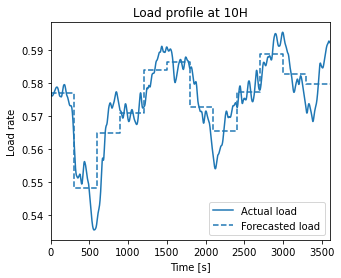

In [33]:
load_pic

## plot scheduling results

### plot cost
data
vis_res: dict
```
    vis_res[f'sg_{idx_ed}'] → dataframe
    vis_res[f'vsg_{idx_ed}'] → dataframe
    vis_res[f'MDsys_{idx_ed}'] → dict
    vis_res[f'dpe_{idx_ed}'] → int
```

sg dataframe: [gen Sn  pg  pru prd ] \
vsg dataframe: [gen  Mvsg  Dvsg pg_vsg  pru_vsg  prd_vsg  pmax_vsg  pmin_vsg] \
MDsys: {'Msys': ..., 'Dsys': ..., 'Rsys': ..., 'Fsys': ...}

In [34]:
# ----------------------- Cost data ----------------------

base_cost = np.array(linearcost)

total_cost = []
delta_Pe = []
gen_cost = []
vsg_reserve_cost = []

for idx in range(12):
    # delta Pe
    delta_Pe.append(vis_res[f'dpe_{idx}'])
    # gen cost
    gen_cost.append(vis_res[f'cost_{idx}'])
    # vsg reserve cost
    up_reserve = vis_res[f'sg_{idx}']['pru'].values * 15
    dn_reserve = vis_res[f'sg_{idx}']['prd'].values * 15
    reserve = up_reserve + dn_reserve
    cost_reserve = np.inner(reserve, base_cost)
    vsg_reserve_cost.append(cost_reserve)
    # total cost
    total_cost.append(gen_cost[idx] + cost_reserve)

# update the first interval
delta_Pe[0] = delta_Pe[1]/2
total_cost[0] += vsg_reserve_cost[0]
vsg_reserve_cost[0] = vsg_reserve_cost[1]/2

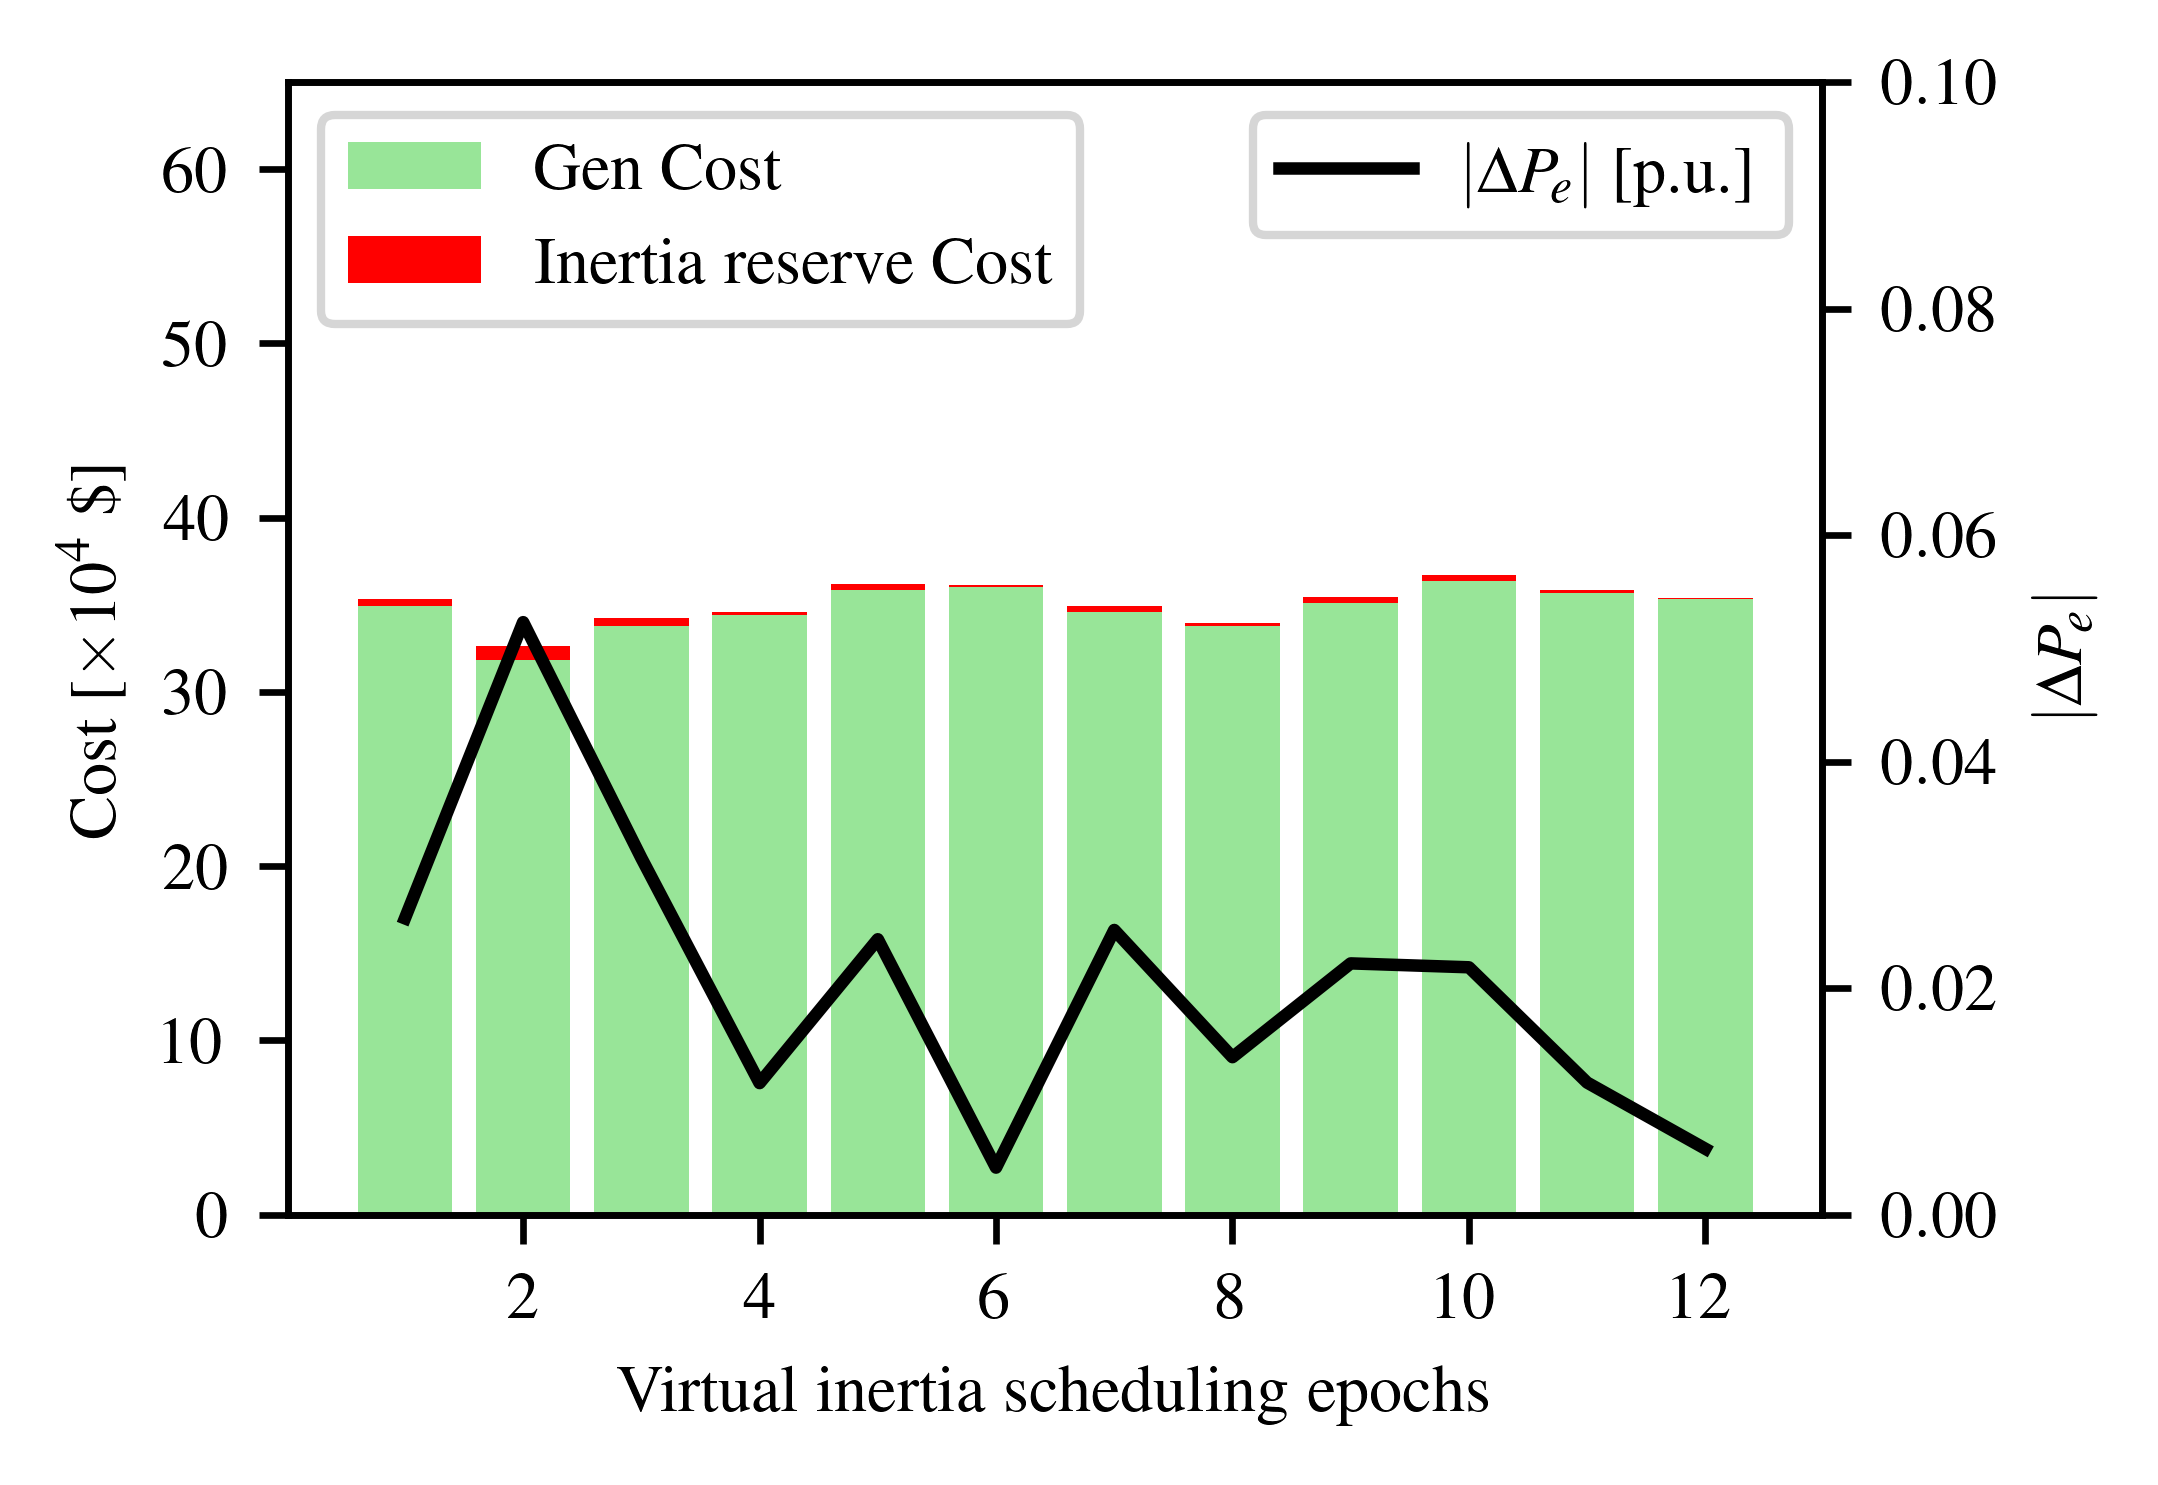

In [35]:
plt.style.use('ieee')
plt.rcParams['text.usetex'] = True

x = np.arange(1, 13, 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# ax1: cost results
ax1.bar(
            x, 
            gen_cost, 
            color='limegreen',
            label='Gen Cost',
            alpha=0.5
        )
ax1.bar(
            x,  
            np.array(vsg_reserve_cost)*2, 
            bottom=gen_cost,
            color='red',
            label='Inertia reserve Cost',
        )
ax1.set_ylim(0, 65)
ax1.set_xlabel('Virtual inertia scheduling epochs')
ax1.set_ylabel(r'Cost [$\times {10}^4$ \$]')
ax1.legend(loc='upper left')

# ax2: delta Pe
ax2.plot(
            x, 
            abs(np.array(delta_Pe)),
            linestyle = '-',
            color='black', 
            label=r'$|\Delta P_e|$ [p.u.]'
        )

ax2.set_xlabel='Virtual inertia scheduling interval' 
ax2.set_ylabel(r'$|\Delta P_e|$')
ax2.set_ylim(-0, 0.1)
ax2.legend(loc='upper right')

### plot M and D

In [36]:
# ----------------------- dynamic scheduling data ----------------------

Msys, Dsys = [], []
Mvsg1, Dvsg1 = [], []
Mvsg2, Dvsg2 = [], []
Mvsg3, Dvsg3 = [], []
Mvsg4, Dvsg4 = [], []

for idx in range(12):
    # Msys, Dsys
    Msys.append(vis_res[f'MDsys_{idx}']['Msys'])
    Dsys.append(vis_res[f'MDsys_{idx}']['Dsys'])
    # Mvsg1, Dvsg1
    Mvsg1.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[0])
    Dvsg1.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[0])
    # Mvsg2, Dvsg2
    Mvsg2.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[1])
    Dvsg2.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[1])
    # Mvsg3, Dvsg3
    Mvsg3.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[2])
    Dvsg3.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[2])
    # Mvsg4, Dvsg4
    Mvsg4.append(vis_res[f'vsg_{idx}']['Mvsg'].iloc[3])
    Dvsg4.append(vis_res[f'vsg_{idx}']['Dvsg'].iloc[3])


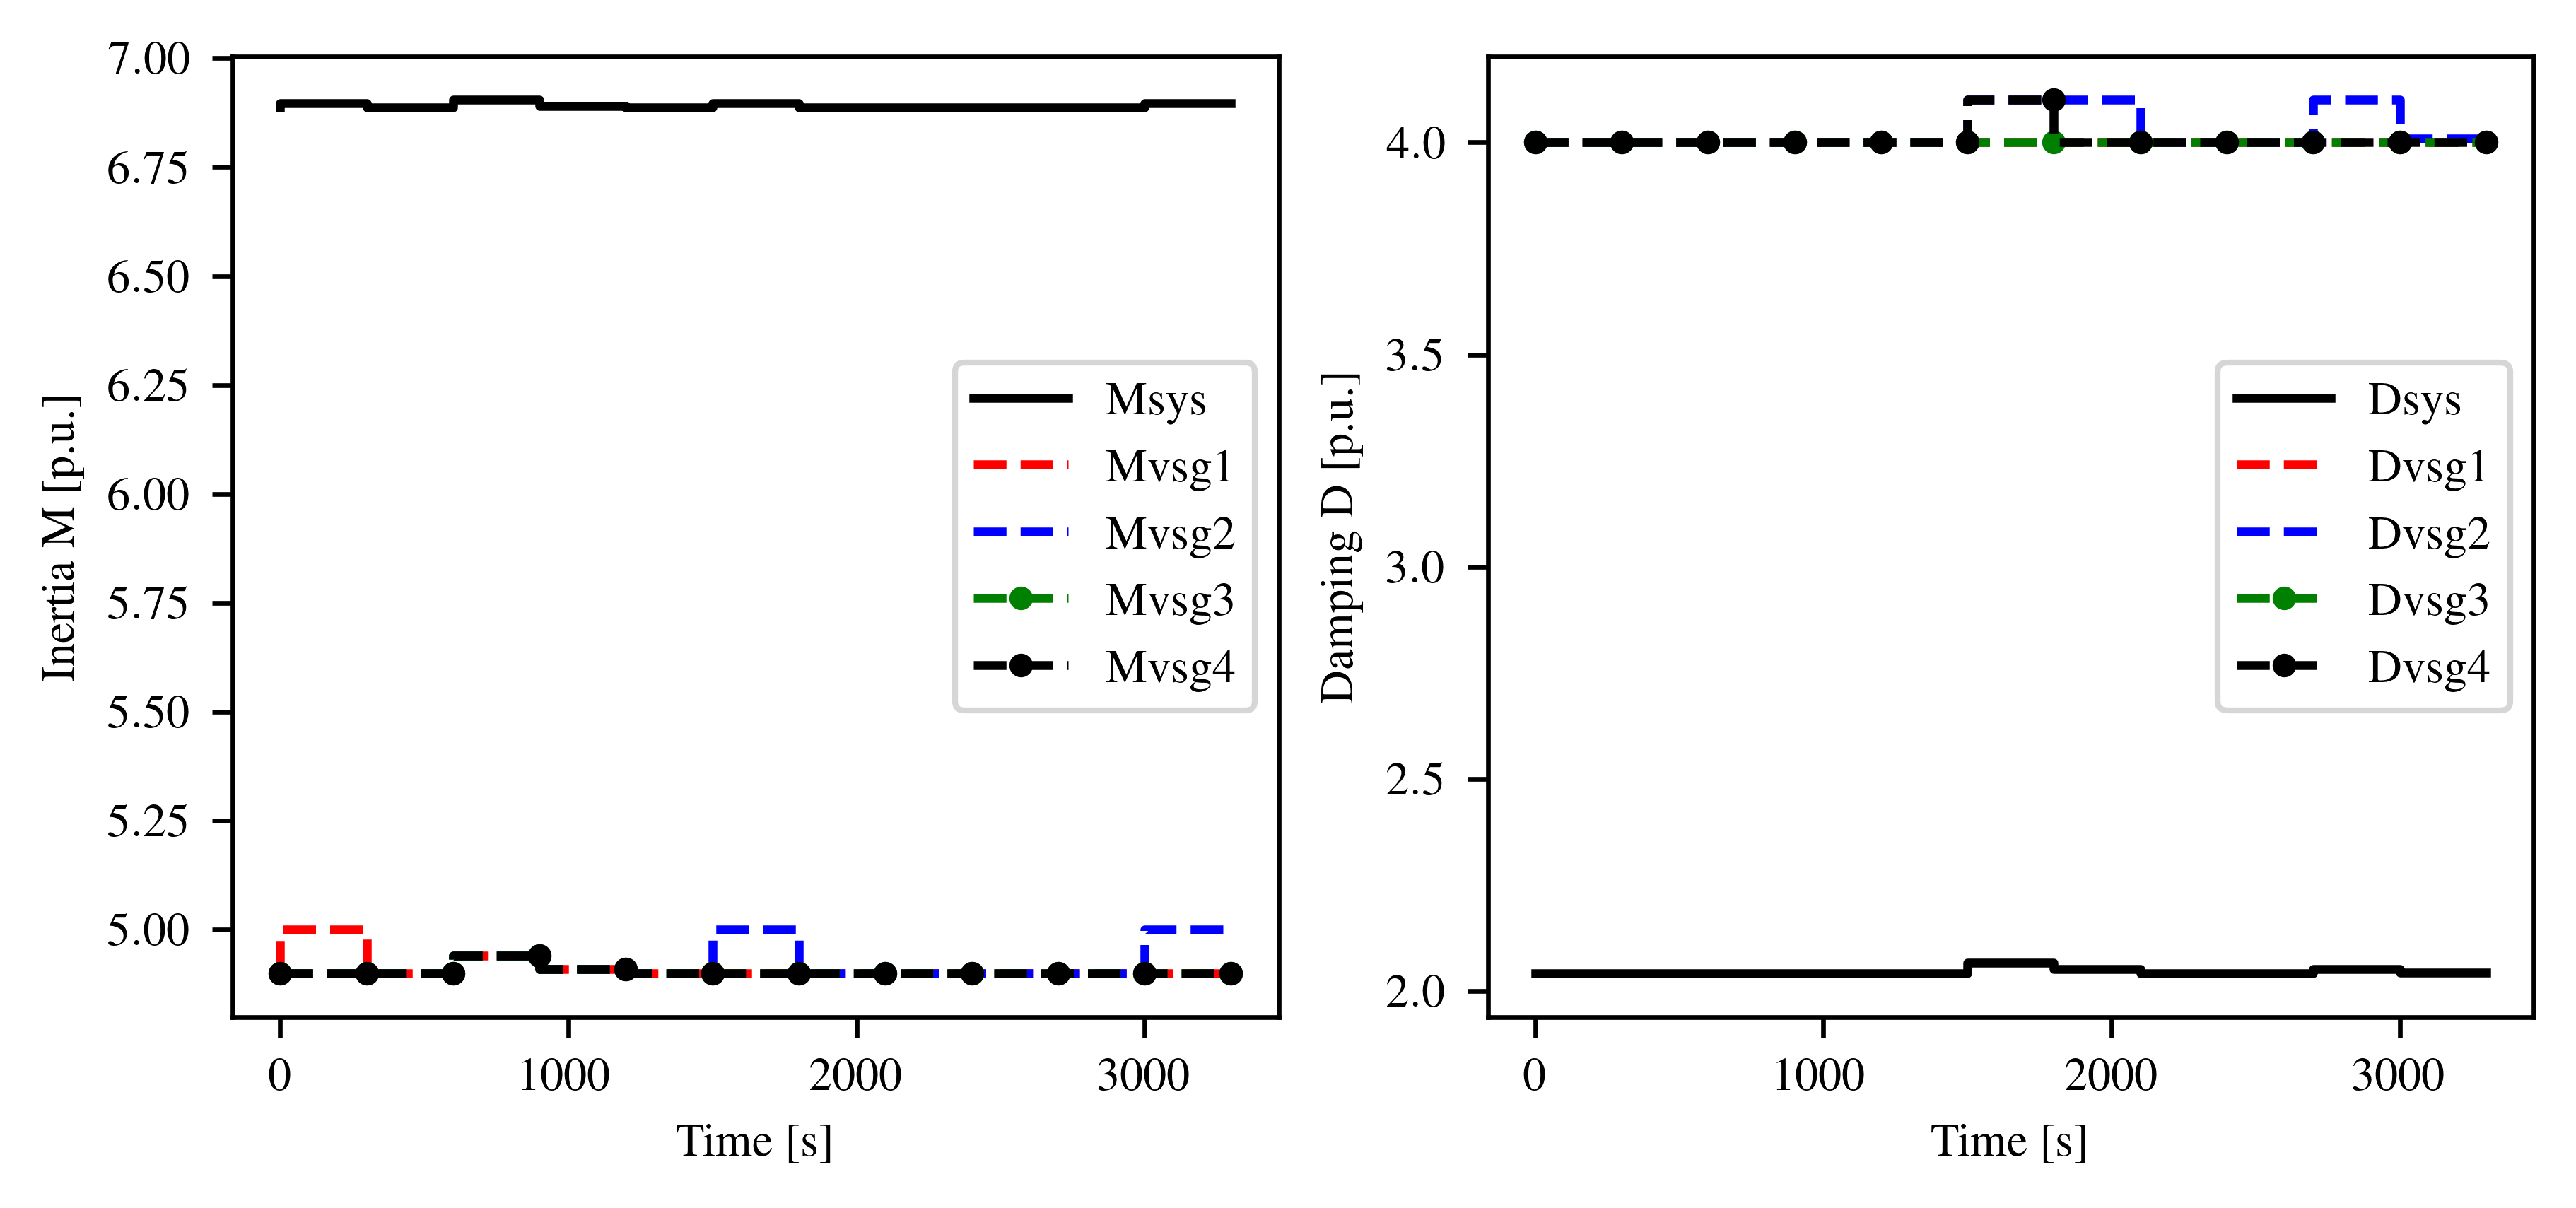

In [37]:
fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.step(range(0,3600,300), Msys, '-', label='Msys')
ax1.step(range(0,3600,300), Mvsg1, '--', label='Mvsg1')
ax1.step(range(0,3600,300), Mvsg2, '--', label='Mvsg2')
ax1.step(range(0,3600,300), Mvsg3, '--.', label='Mvsg3')
ax1.step(range(0,3600,300), Mvsg4, '--.', label='Mvsg4')

ax1.set_ylabel('Inertia M [p.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend()

ax2.step(range(0,3600,300), Dsys, '-', label='Dsys')
ax2.step(range(0,3600,300), Dvsg1, '--', label='Dvsg1')
ax2.step(range(0,3600,300), Dvsg2, '--', label='Dvsg2')
ax2.step(range(0,3600,300), Dvsg3, '--.', label='Dvsg3')
ax2.step(range(0,3600,300), Dvsg4, '--.', label='Dvsg4')

ax2.set_ylabel('Damping D [p.u.]')
ax2.set_xlabel('Time [s]')
ax2.legend()


In [38]:
delta_Pe

[-0.02615329065484151,
 -0.05230658130968302,
 0.03147536086829672,
 0.011602255296603081,
 0.02430699329944286,
 0.004140114047862298,
 -0.025126883789984955,
 -0.01389213484529872,
 0.022174488776375734,
 0.021830130309329343,
 -0.011650098622755456,
 -0.005803957313171848]

### plot $\Delta P_e$ and VSG reserved capacity

In [39]:
# get data
delta_Pe

total_rs = []
vsg1_rs = []
vsg2_rs = []
vsg3_rs = []
vsg4_rs = []

for idx in range(12):
    # total reserve
    vsg_rsu = vis_res[f'vsg_{idx}']['pru_vsg'].values * 15
    vsg_rsd = vis_res[f'vsg_{idx}']['prd_vsg'].values * 15
    vsg_rs = vsg_rsu - vsg_rsd
    total_rs.append(vsg_rs.sum())
    # vsg1 reserve
    vsg1_rs.append(vsg_rsu[0] - vsg_rsd[0])
    # vsg2 reserve
    vsg2_rs.append(vsg_rsu[1] - vsg_rsd[1])
    # vsg3 reserve
    vsg3_rs.append(vsg_rsu[2] - vsg_rsd[2])
    # vsg4 reserve
    vsg4_rs.append(vsg_rsu[3] - vsg_rsd[3])

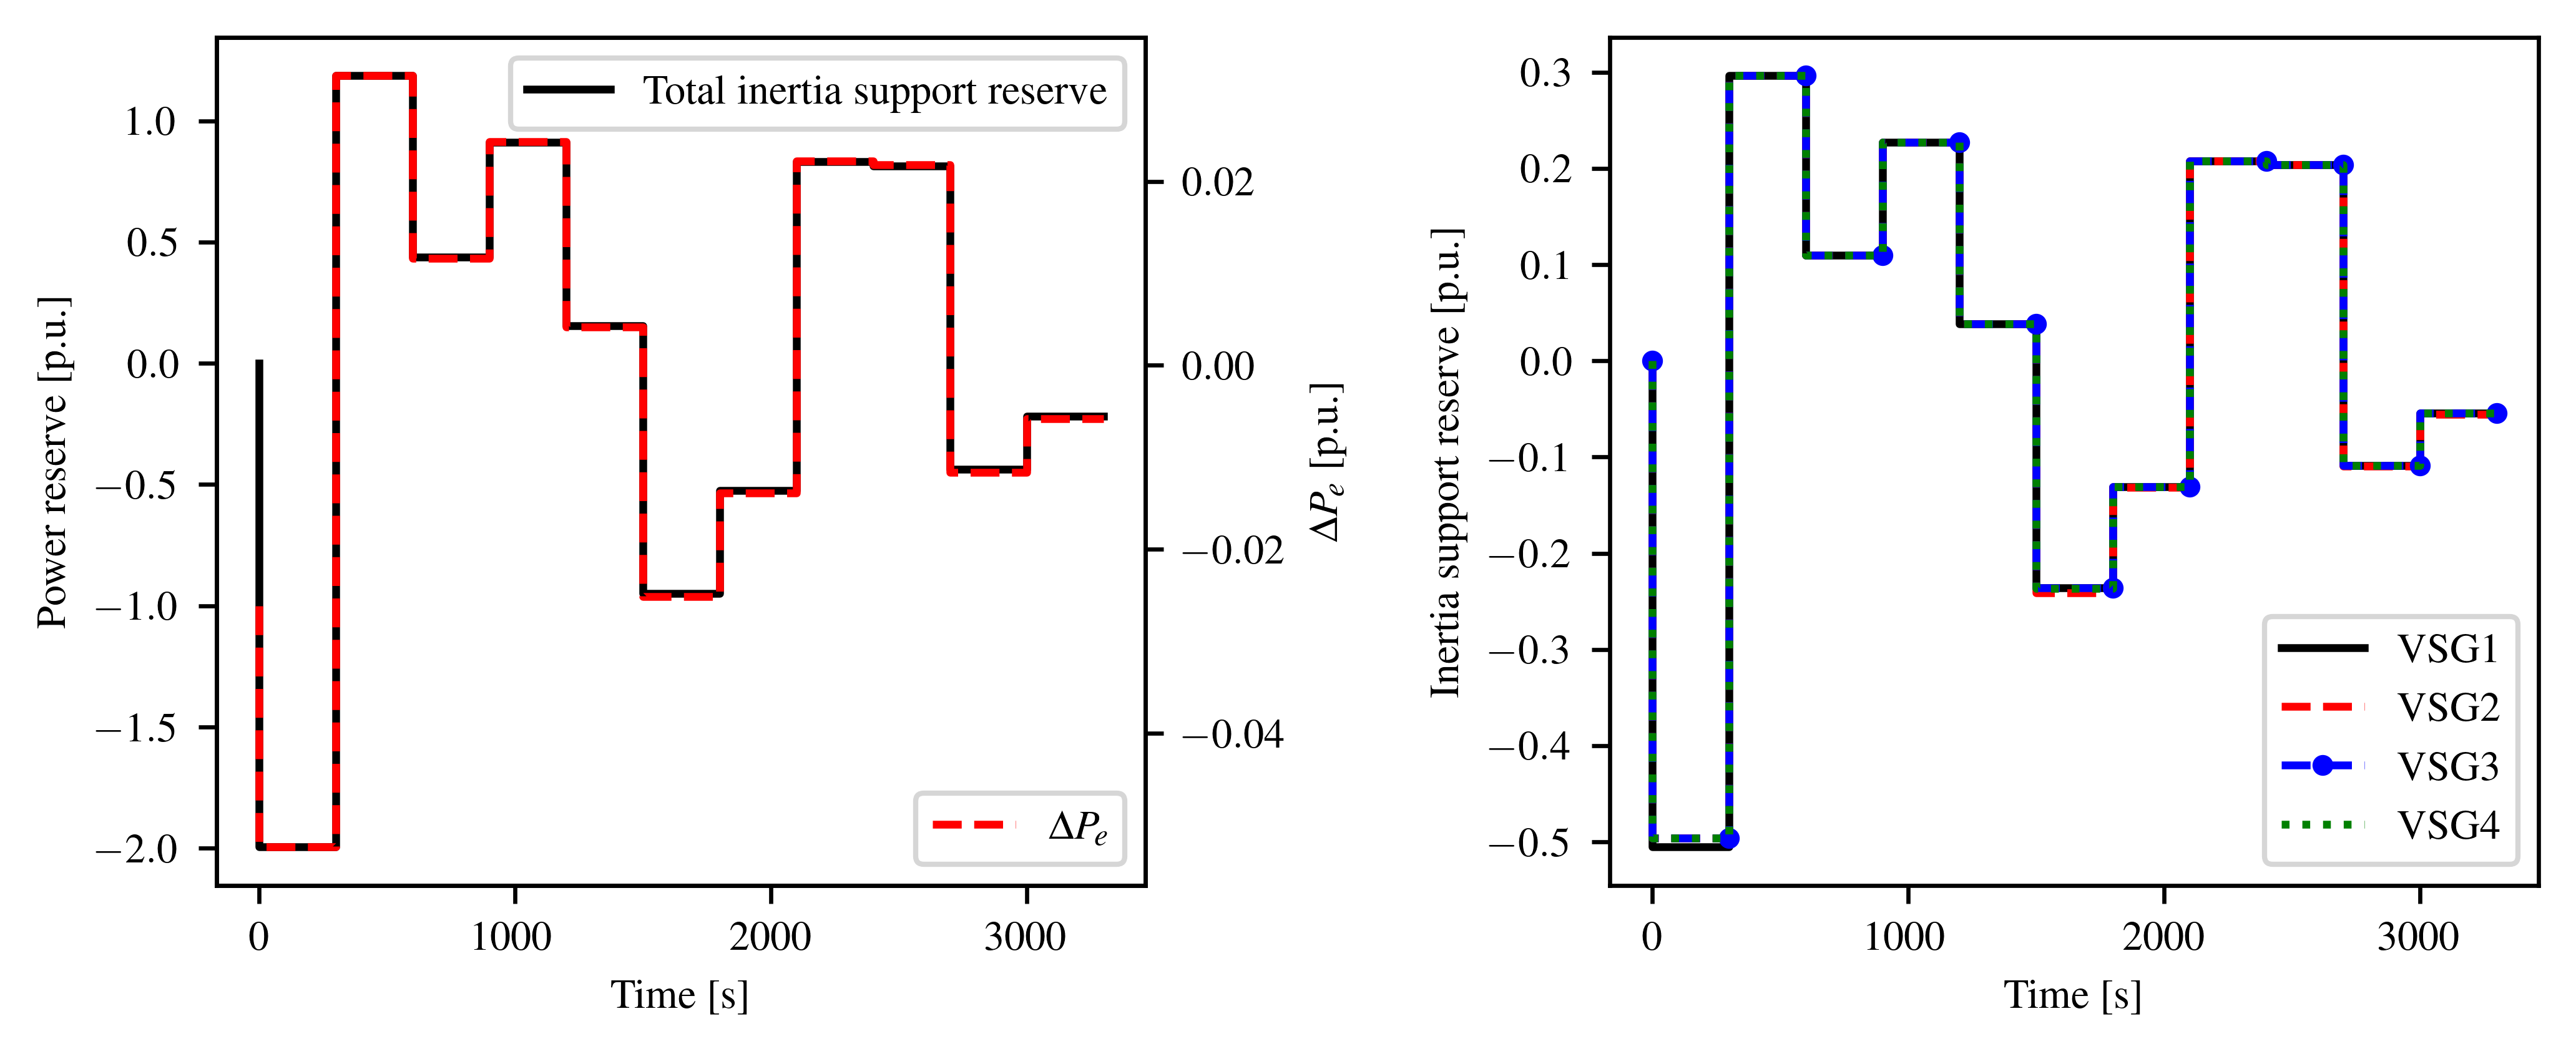

In [40]:
fig = plt.figure(figsize=(8, 3))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.5, hspace=0.6)
ax1 = fig.add_subplot(121) # total reserve
ax2 = fig.add_subplot(122)

ax1_twin = ax1.twinx() # delta Pe

# ----------------------- total reserve ----------------------
ax1.step(range(0,3600,300), total_rs, '-', label='Total inertia support reserve')
ax1.set_ylabel('Power reserve [p.u.]')
ax1.set_xlabel('Time [s]')
ax1.legend(loc='upper right')

ax1_twin.step(range(0,3600,300), delta_Pe, '--', color='red', label=r'$\Delta P_e$')
ax1_twin.set_ylabel(r'$\Delta P_e$ [p.u.]')
ax1_twin.legend(loc='lower right')

# ----------------------- VSG pwoer reserve ----------------------
ax2.step(range(0,3600,300), vsg1_rs, '-', label='VSG1')
ax2.step(range(0,3600,300), vsg2_rs, '--', label='VSG2')
ax2.step(range(0,3600,300), vsg3_rs, '--.', label='VSG3')
ax2.step(range(0,3600,300), vsg4_rs, ':', label='VSG4')

ax2.set_ylabel('Inertia support reserve [p.u.]')
ax2.set_xlabel('Time [s]')
ax2.legend()

## plot TDS results

hline1, hline2, vline1, and vline2 are deprecated. Use `hline` and `vline`.
hline1, hline2, vline1, and vline2 are deprecated. Use `hline` and `vline`.


(<Figure size 9600x4800 with 8 Axes>,
 <AxesSubplot:title={'center':'Pe of VSG'}, xlabel='Time [s]', ylabel='Pe [p.u.]'>)

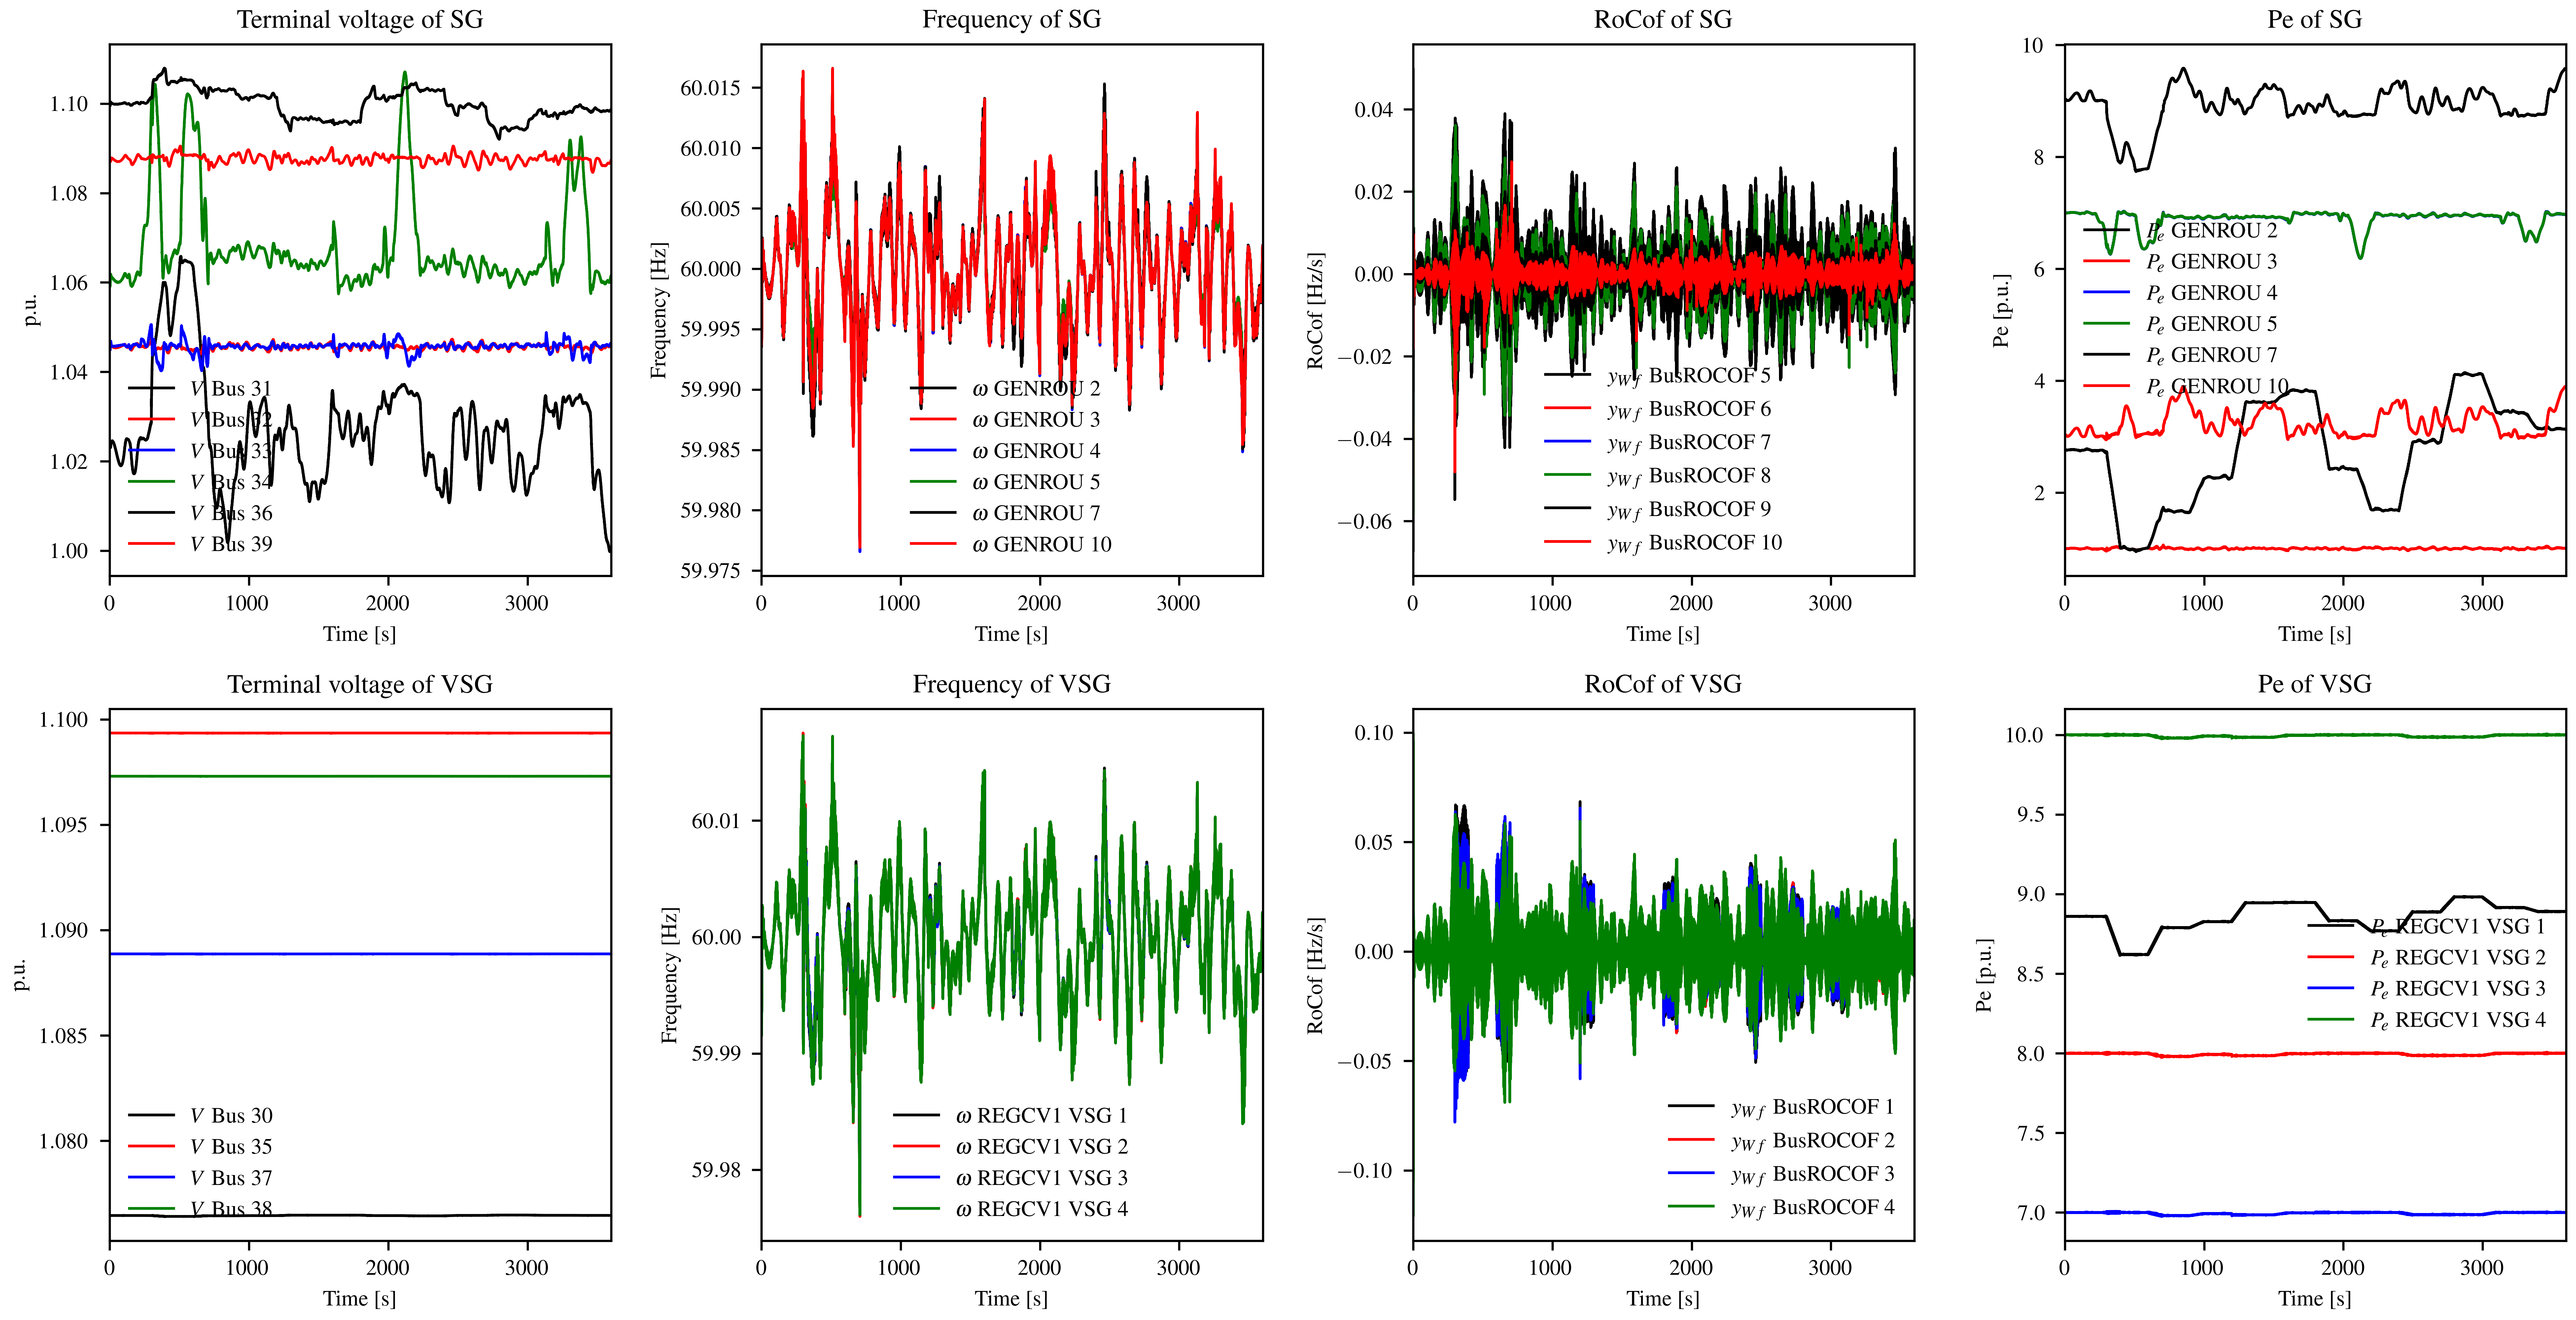

In [41]:
# TODO: change label and length of plot

fig_gen, ax_gen = plt.subplots(2, 4, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.25)

# voltage
ssa.TDS.plt.plot(
                    ssa.GENROU.v,
                    linestyles=['-'], style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'Terminal voltage of SG',
                    ylabel='p.u.',
                    fig=fig_gen, 
                    ax=ax_gen[0, 0]
                )

ssa.TDS.plt.plot(
                    ssa.REGCV1.v,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'Terminal voltage of VSG',
                    ylabel='p.u.',
                    fig=fig_gen, 
                    ax=ax_gen[1, 0]
                )

# frequency
ssa.TDS.plt.plot(
                    ssa.GENROU.omega,
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'Frequency of SG',
                    ylabel='Frequency [Hz]',
                    fig=fig_gen, 
                    ax=ax_gen[0, 1],
                    hline1=59.9,
                    hline2=60.1
                )

ssa.TDS.plt.plot(
                    ssa.REGCV1.omega,
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'Frequency of VSG',
                    ylabel='Frequency [Hz]',
                    fig=fig_gen, 
                    ax=ax_gen[1, 1],
                    hline1=59.9,
                    hline2=60.1
                )

# rocof
ssa.TDS.plt.plot(
                    ssa.BusROCOF.Wf_y,
                    a =(4,5,6,7,8,9),
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'RoCof of SG',
                    ylabel='RoCof [Hz/s]',
                    fig=fig_gen, 
                    ax=ax_gen[0, 2]
                )

ssa.TDS.plt.plot(
                    ssa.BusROCOF.Wf_y,
                    a =(0,1,2,3),
                    ytimes=60,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'RoCof of VSG',
                    ylabel='RoCof [Hz/s]',
                    fig=fig_gen, 
                    ax=ax_gen[1, 2]
                )

# Pe
ssa.TDS.plt.plot(
                    ssa.GENROU.Pe,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'Pe of SG',
                    ylabel='Pe [p.u.]',
                    fig=fig_gen, 
                    ax=ax_gen[0, 3]
                )

ssa.TDS.plt.plot(
                    ssa.REGCV1.Pe,
                    linestyles=['-'], 
                    style='ieee',
                    # yheader=yheader,
                    legend=True, 
                    show=False, 
                    right=t_total,
                    title=r'Pe of VSG',
                    ylabel='Pe [p.u.]',
                    fig=fig_gen, 
                    ax=ax_gen[1, 3]
                )

andes plot ref:

https://docs.andes.app/en/latest/_modules/andes/plot.html#tdsplot

can search hline

1) save data and replot

https://docs.andes.app/en/latest/_examples/ex2.html#extracting-variable-data
